In [2]:
from scipy.stats import expon
import numpy as np
from math import factorial
import matplotlib.pyplot as plt
import dill
from astropy import visualization as vis
from gammapy.data import DataStore, Observation
import scanner_interpretation as scani
from corner import corner

# with open("pkl_jugs/reduced_with_significance.pkl","rb") as f:
#     reduced = dill.load(f)

print("Getting Reduced")
reduced = scani.Reduced("pkl_jugs/reduced_with_alt.pkl")
# print("Loading metadata (~40sec)")
# reduced.loadMetadata("pkl_jugs/navigationtable.pkl")
# reduced.loadNavtable("pkl_jugs/navigationtable.pkl")
# reduced.loadObservations()

pval_0_mask = reduced.reduced["LAMBDA_RATIO_SIGNIFICANCE"]==0.


Getting Reduced


In [ ]:
A = reduced.reduced[~pval_0_mask]
A.sort("LAMBDA_RATIO_SIGNIFICANCE")
cand = A[2]

luminosity = np.sum(cand["ENERGY"])/cand["dt"] * 1.6 * (4*np.pi * (3e24)**2 / 1e5) * 1e9
print(luminosity)

In [4]:
reduced.reduced["LOG_SIGNIFICANCE"] = np.log10(reduced.reduced["LAMBDA_RATIO_SIGNIFICANCE"])


/tmp/ipykernel_170512/3073421562.py:1: RuntimeWarning: divide by zero encountered in log10
  reduced.reduced["LOG_SIGNIFICANCE"] = np.log10(reduced.reduced["LAMBDA_RATIO_SIGNIFICANCE"])


In [15]:
from scipy.stats import spearmanr
spearmanR = spearmanr(reduced.reduced[~pval_0_mask]["LAMBDA_RATIO_SIGNIFICANCE"].data,reduced.reduced[~pval_0_mask]["PNT_DISTANCE"].data)
print(spearmanR)

SpearmanrResult(correlation=-0.2465726932886005, pvalue=0.0)


In [20]:
spearmanR.correlation

-0.2465726932886005

Pandas support in corner is deprecated; use ArviZ directly


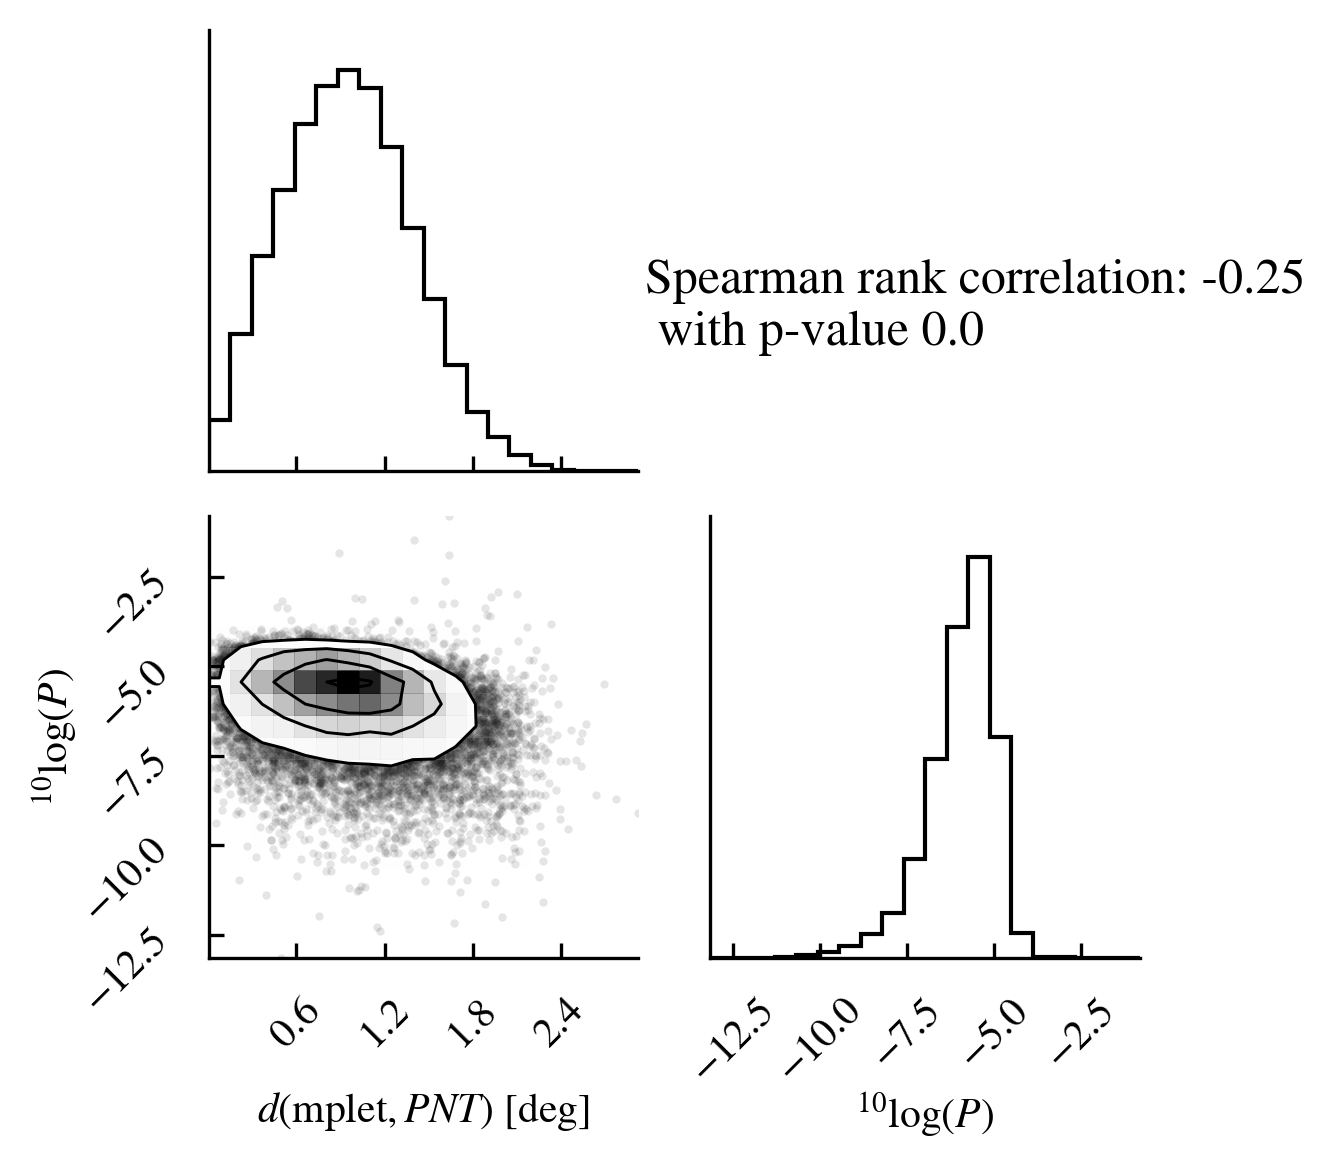

In [35]:
fig = corner(reduced.reduced[~pval_0_mask].to_pandas(),var_names=["PNT_DISTANCE","LOG_SIGNIFICANCE"],labels=[r"$d(\mathrm{mplet}, PNT)$ [deg]",r"$^{10}\log(P)$"])
fig.text(.55,.7,f"Spearman rank correlation: {np.round(spearmanR.correlation,2)}\n with p-value {spearmanR.pvalue}",fontsize="large")
fig.set_size_inches(4,4)
plt.savefig("figures/combined/pnt-significance-correlation.png",facecolor="white",dpi=300)

In [ ]:
with open("pkl_jugs/plotter_pval0/multiplets.pkl","wb") as f:
    dill.dump(reduced[pval_0_mask],f)

## badly marked: 18361

In [ ]:
reduced[pval_0_mask]["OBS_ID"].data

In [ ]:
h = vis.hist(reduced["ANGULAR_MEASURE_DEG"],histtype="step",bins="freedman")
plt.title("Mean of multiplet photon distance to median coordinate")
plt.xlabel("Distance [deg]")
plt.ylabel("Counts")

In [ ]:
min(reduced["LAMBDA_RATIO_SIGNIFICANCE"][~pval_0_mask]),max(reduced["LAMBDA_RATIO_SIGNIFICANCE"])

Significance histogram excluding pval==0

In [ ]:
plt.figure(figsize=(5,2.5))
h = vis.hist(np.log10(reduced.reduced[~pval_0_mask]["LAMBDA_RATIO_SIGNIFICANCE"]),histtype="step",bins=np.linspace(-14,0))
plt.yscale("log")
plt.xlabel(r"$^{10}\log(P)$")
plt.ylabel("Counts")
plt.title("$P(N\geq N_m ~|~ \lambda)$",loc="left")
# plt.savefig("figures/combined/lambda_ratio_significance.pdf")
plt.savefig("figures/combined/lambda_ratio_significance.png",facecolor="white",dpi=300)
# h = vis.hist(reduced["MPLET_DT_LAMBDA"],histtype="step",bins=np.linspace(6e-19,9.5e-19,100))

In [ ]:
reduced.sort('dt')
pval_0_mask = reduced["LAMBDA_RATIO_SIGNIFICANCE"]==0.

len(np.unique(reduced[pval_0_mask]["OBS_ID"]))

In [ ]:
h = vis.hist(reduced["dt"][reduced["LAMBDA_RATIO_SIGNIFICANCE"] < 1e-5],histtype="step",bins="freedman")
# reduced[(reduced["LAMBDA_RATIO_SIGNIFICANCE"] < 1e-7)*(reduced["dt"] > 27e8)]

In [ ]:
candidates = reduced[reduced["POISSON_SIGNIFICANCE"] < 1e-5]

### To do

1. Check fit compared to histogram and mplet dt
2. Verify on a skymap that the masked photons correspond to near the source
3. Do a time spread of the photon arrival times to guess if a cloud is passing by
4. Do a gammapy analysis
5. Ask victor if the m87 run is excluded (done)
6. check GRBCAT

In [ ]:
ds = scani.getDataStores()
obs = [myds.get_observations(candidates["OBS_ID"],skip_missing=True) for myds in ds]
m87_obs = obs[1][0]
m87_mplet = candidates[-1]


In [ ]:
m87_mplet

In [ ]:
m87_rundist = scani.sphere_dist(m87_obs.events.table["RA"].data,m87_obs.events.table["DEC"].data,m87_mplet["MEDIAN_RA"],m87_mplet["MEDIAN_DEC"])

plt.scatter(1e-9*(m87_obs.events.table[m87_rundist<.1]["TIME"]),np.zeros_like(m87_obs.events.table[m87_rundist<.1]["TIME"]),marker="v",s=1)

In [ ]:
expon.fit(np.diff(np.sort(m87_obs.events.table[m87_rundist < 0.1]["TIME"])),floc=0)

In [ ]:
dwarf = SkyCoord(283.775,-30.483,frame="fk5",unit="deg")
dwarf.separation(reduced[(reduced["OBS_ID"]==64292) * (reduced["POISSON_SIGNIFICANCE"] < 1e-5)]["SkyCoord"])

In [ ]:
h = vis.hist(np.log10(reduced["dt"]),bins="freedman",histtype="step")
plt.yscale("log")

In [ ]:
N = 3
livetime = 1680
bursttime = 3
rate = N/livetime

lamb = rate*bursttime
sum = 1
for i in range(3):
    sum -= (lamb)**i * np.exp(-lamb) / factorial(i)

sum
